# Week 7 Notebook 3 Case Study


## Web Scraping Workflow

In the previous notebook, we learned how to use the BeautifulSoup library. Now, let's apply the web scraping workflow for data analysis.

In this lesson, we will:
1. Use the `Requests` library to get the HTML source for a web page
1. Scrape data using `BeautifulSoup`
2. Save the results into a CSV file using `Pandas`.

First, we have to import the required libraries.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Using the Requests Library

First, we will use the `Requests` library to obtain the target HTML page. 

We are going to use the [Wikipedia page on country GDP](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)) to show how we can extract data from a table. Take a look at the web page. We want to get the GDP data for each country.

In [ ]:
# Send a request to get the HTML page on country GDP from Wikipedia
web_url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)"
response = requests.get(web_url)

if (response.status_code == 200):
    print(response.headers['Content-Type'])

    print()
else:
    print(response.reason)

# Using the BeautifulSoup Library

Since the response content type is `text/html`, we can proceed to create the `BeautifulSoup` object for scraping.

In [ ]:
# Parse the response using BeautifulSoup
soup = BeautifulSoup(response.content,'html.parser')

**Find tables**

We know that the data that we want is in a table. Let's check how many tables there are.

In [ ]:
tables = soup.find_all("table")
print("Number of table tags found:", len(tables))

Since there is more than one table, we need to find the *correct* table. We can do this by inspecting the element to determine if there are any identifying attributes.

First, let's see what the attributes of the various tables are.

In [ ]:
# Print the table attributes
for table in tables:
    print(table.attrs)

**Inspect the Element**

If we hover our cursor on the GDP table, right-click and choose to `Inspect Element`, we can see the table attributes that we want. 

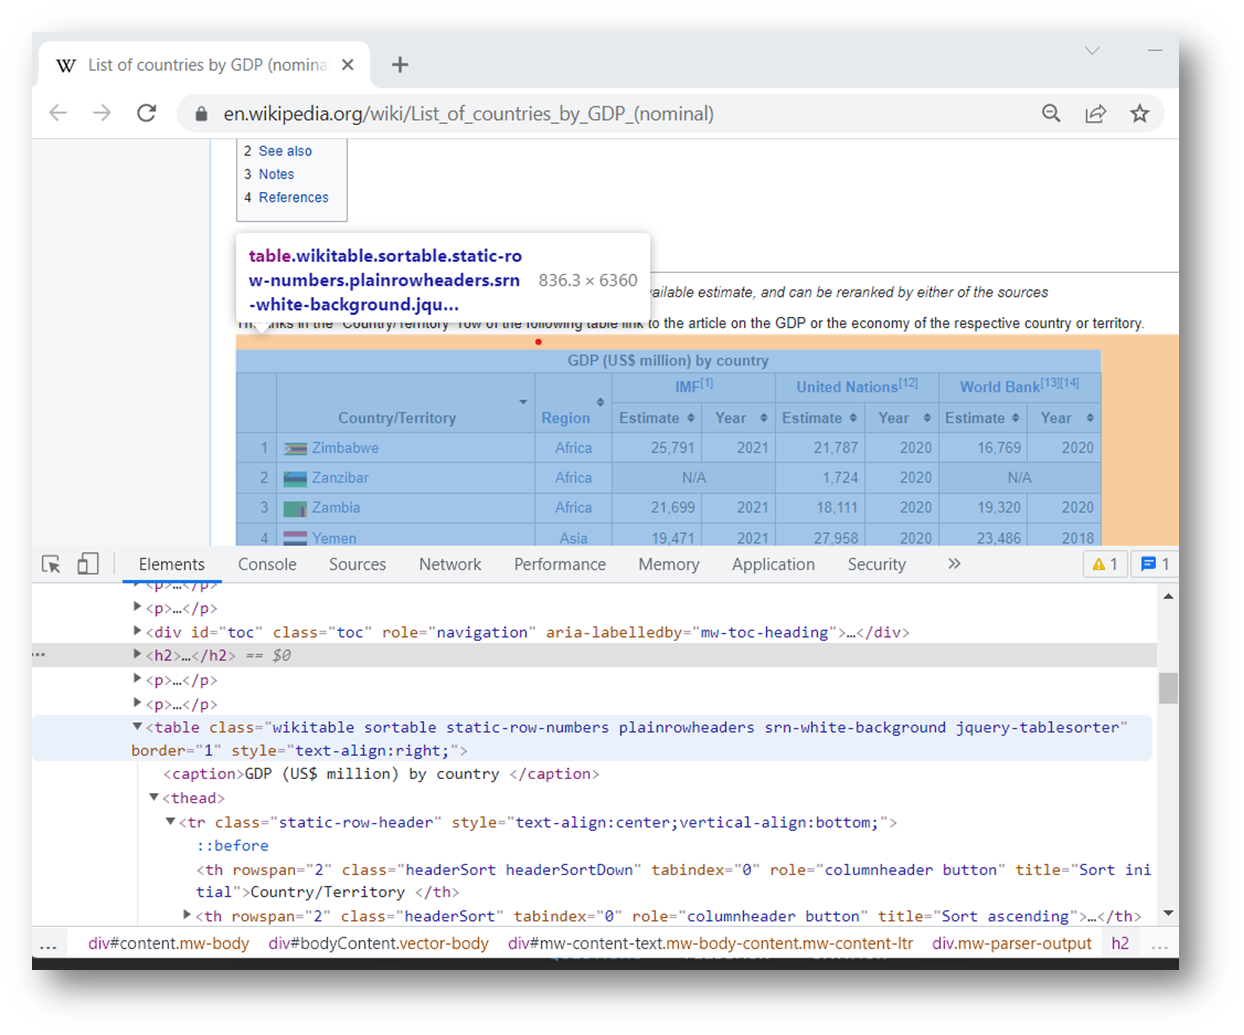

For this table, we want the value for the `class` attribute to be 'wikitable', 'sortable', etc. We can use just the first value to find it.

In [ ]:
gdp_table = soup.find(class_='wikitable')

# Another way 
# gdp_table = soup.find("table", {'class':'wikitable'})  

print(gdp_table.text)

Great! We have successfully located the table. However, what about the data? We can have a look at the various child tags of the `<table>` tag.

In [ ]:
# Display the table element and all its children
gdp_table


**Scraping the Table**

We need to process each of the table rows. Looking at the tags above, we might notice that the first two rows are the header names and the data is found in the third row onwards. We will scrape the data and, for each row, store the data from the `<td>` tags in a `List` object. We have to check the formatting in the original table. 

For example, for Cuba, the IMF Estimate was not recorded, so the data spans two columns and is recorded as `N/A`.
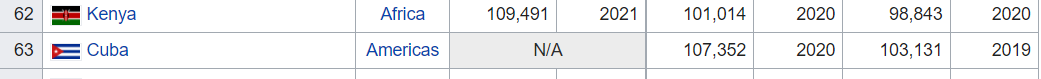

The headers also take up two rows. So, instead of scraping it, we will form the header row with the appropriate column titles. 

In [ ]:
# Store the table as a list of rows
rows = []

# prepare a list of header names
headerRow = ['Country', 'Region', 'IMF Estimate', 'IMF Year', 'UN Estimate', 'UN Year','World Bank Estimate', 'WB Year']

# add the header row to the list of rows
rows.append(headerRow)

# Get all the rows with data (from row 2 onwards)
table_rows = gdp_table.find_all("tr")[2:]

# go through each row
for table_row in table_rows:       
    
    # get the data tags
    td = table_row.find_all("td")        
    
    # prepare to store in a row
    temp_row =[]    
    
    # for each <td> tag in the row, store the data if it is available
    for content in td:
        data = content.get_text(strip=True)      # remove whitespaces such as \n
        if data == 'N/A':                        # data was not recorded 
            temp_row.extend(['NaN','NaN'])       # put NaN for the gdp estimate and the year
        else:
            temp_row.append(data)  
        
    # add this row to the list 
    rows.append(temp_row)                
    

**Show the Scraped Data**

Now that we have scraped each row, let's check what we have.

In [ ]:
for row in rows:
    print(row)

# Using the Pandas Library

Now, we will use Pandas to form our List of rows neatly into a DataFrame object.

**Create a DataFrame**

The `DataFrame` constructor creates a DataFrame. The `data=` argument specifies the data that will form the DataFrame rows, and the `columns=` argument specifies the column names. 

Since we have stored the headers in `row[0]` of our scraped data, this will be the value for the `columns=` argument. Our data is stored in row indexed from 1 up to the end.

In [ ]:
import pandas as pd

# Create a DataFrame
gdp_df = pd.DataFrame(data = rows[1:], columns=rows[0])
gdp_df.head()

**Saving to a File**

As we can see, we have a pretty neat DataFrame. It is still not perfect, so we will have to do some data cleaning. Now, we can save this DataFrame into a CSV file using the `to_csv()` method.

In [ ]:
# Save DataFrame to a file
gdp_df.to_csv('gdp_estimates.csv')

If we type `ls` to list the contents of the current directory, we should see the file `gdp_estimates.csv`.

In [ ]:
ls

**Reading the File**

Now we can read in the file as we have done before, with some additional arguments to help clean the data such, as converting the numeric values based on the thousands separator.

In [ ]:
# Reading from file with the first column as the index column and numbers using the thousands separator 

gdp_fromfile = pd.read_csv('gdp_estimates.csv', index_col=0, thousands = ',')

We can check the previously read in DataFrame. It still needs some cleaning, but we will leave this for now.

In [ ]:
gdp_fromfile

## Using Pandas to Parse HTML

Pandas also has a `read_html` function that can be used to direcly parse HTML.

In [ ]:
# Find the <table> tag required
gdp_html = soup.find("table", {'class':'wikitable'})

# Use pandas to convert the HTML into a list of DataFrame objects
df_list = pd.read_html(str(gdp_html))

# The table we want is the first one
gdp_df = df_list[0]
gdp_df.head()

As we can see, even though there may still be some cleaning required, the DataFrame that is created is nicely formatted. So, we could use this version and save it to a CSV file as before.

# Exercises

Let's try to extract data from another Wikipedia page: [List of Metropolitan Areas in Asia]( https://en.wikipedia.org/wiki/List_of_metropolitan_areas_in_Asia).

**Q1. Create BeautifulSoup Object**

Create a `BeautifulSoup` object to scrape the content from this page!

In [ ]:
# Q1 Answer


**Q2. Find Particular Tag**

Locate the tag which contains the table with the data of each metropolitan area and name it `met_table`!

In [ ]:
# Q2 Answer


**Q3. Scraping Table**

Scrape the table, but store only six items:
1. Rank
2. Area
3. Link to the image file
4. Country
5. Metro Population
6. Demographia (which will provide all numeric values)

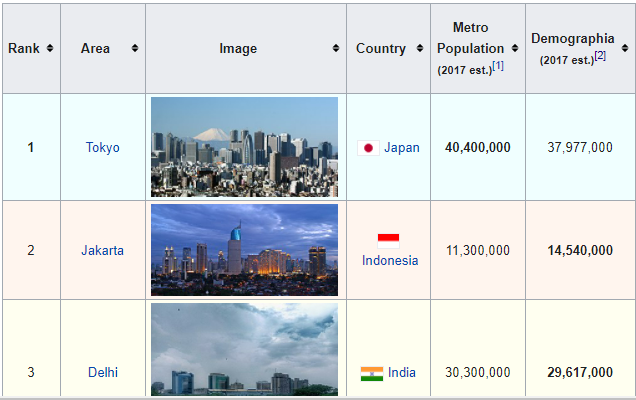

The region is given by the background colour of the cell:
- #F0FFFF : East Asia
- #FFFFF0 : South Asia
- #FFF5EE : Southeast Asia
- #F0F8FF : West Asia

We will create a Dictionary so that we can look up the values of the region based on the background colour easily.

In [ ]:
# Q3 Answer
# Use this dictionary to look up the region
region_dict = {'#F0FFFF':'East Asia', '#FFFFF0' : 'South Asia', '#FFF5EE' : 'Southeast Asia', '#F0F8FF' : 'West Asia'}

#Store the table as a list of rows
rows = []

#prepare a list of header names


# Get all the rows with data


# go through each row
   
    
    #prepare to store a new row
   
    
    # get the data tags
          
    
    # add the rank value
   
        
    # add the area name
  
    # add the link to the image
   
    
    # add the country
   
   
    # add the metro population
    
    
    # add the demographia population
   
   
    # look up the region based on the background color of the row and add to temp_row
    
    # add this row to the list 

# check whether the rows were added successfully
for row in rows:
    print(row)

**Q4. Create DataFramme**

Convert the rows to a `DataFrame` object!

In [ ]:
#Q4 Answer


**Q5. Save to a File**

Save the file as a CSV file named 'AsianMetropolis.csv'!

In [ ]:
#Q5 Answer


**Q6. Read from a File**

Read in the file!

In [ ]:
# Q6 Answer


**Q7. Total Population Estimation**

Using Pandas `groupby` method, calculate the estimated total population by each Asian region (use the 'Demographia' values as they are numeric)!

In [ ]:
# Q7 Answer
